In [2]:
import numpy as np
import control as ctl
import matplotlib.pyplot as plt


**Exercise 1**

1.1. We can model intravenous drug administration in the body using the following idea: when a drug is administered, then it first spreads throughout the circulatory system and from there to other tissues (for example the muscular system). We call this the "two vessel model" or "two compartment model", where one "vessel" is the circulatory system and the other one the muscular system.

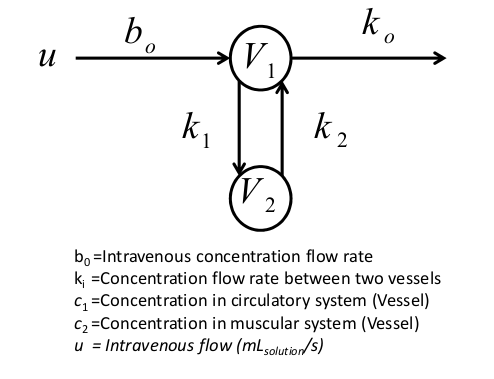

The "equations of motion" that govern this system are:
$$\dot c_1 = -k_1c_1 + k_2c_2 - k_0c_1 + b_0u$$
$$\dot c_2 = k_1c_1 - k_2c_2$$

1.2 Create a state space system for this using values $b_0 = 1.5$, $k_0 = 0.1$, $k_1 = 0.1$ and $k_2 = 0.5$. Pick your states to be the concentrations of the drug in the circulatory and muscular system. The outputs of interest for us are the concentration of the drug in the circulatory as well as the muscular system ($c_2$).

In [37]:
b0 = 1.5
k0 = 0.1
k1 = 0.1
k2 = 0.5

# Create matrices A, B, C and D here
A = np.array([[-k0-k1, k2],[k1, -k2]])
B = np.array([[b0],[0]])
C = np.array([[1,0], [0,1]])
D = np.array([[0], [0]])

Create the state space system using ctl.ss:

In [38]:
sys = ctl.ss(A, B, C, D)

1.3. Analyse how the system responds to a step input.

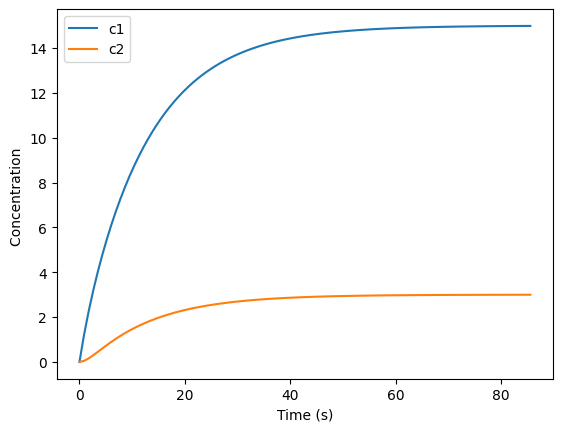

In [39]:
time, outputs = ctl.step_response(sys)


plt.plot(time, outputs[0][0], label="c1")
plt.plot(time, outputs[1][0], label="c2")
plt.xlabel("Time (s)")
plt.ylabel("Concentration ")
plt.legend()
plt.show()

1.4. Determine the eigenvalues of the A matrix using np.linalg.eigvals:

In [40]:
eigvals = np.linalg.eigvals(A)
print("Eigenvalues:", eigvals)

Eigenvalues: [-0.08074176 -0.61925824]


1.5. Analyze the eigenvalues to determine if the system is stable, unstable, or marginally stable. Write down your conclusion.

System is stable, eigenvalues are negative.

Note that “all coefficients of the Characteristic Equation must be nonzero
and have the same sign” in order for the system to be asymptotically
stable.
Characteristic equation is the one with eigenvalues?



1.6. Modify the values $b_0$, $k_0$, $k_1$ and $k_2$ to create different systems with varying stability properties (e.g., stable, unstable, and marginally stable systems). Repeat steps 1.3 to 1.5 for each system and observe the relationship between eigenvalues and system stability. Write down your observations.

**Exercise 2**: Controlling the Concentration

2.1. Re-initialize the values of $b_0$, $k_0$, $k_1$ and $k_2$ to the ones given in task 1.2.

In [45]:
b0 = 1.5
k0 = 0.1
k1 = 0.1
k2 = 0.5

# Create matrices A, B, C and D here
A = np.array([[-k0-k1, k2],[k1, -k2]])
B = np.array([[b0],[0]])
C = np.array([[1,0], [0,1]])
D = np.array([[0], [0]])

sys = ctl.ss(A, B, C, D)

2.2. Find a value of input $u$ (still step input, but not unit step input) such that the concentration of the drug in the musculatory system after a minute and a half is $6$ (mL per 100mL - ignore the units). 

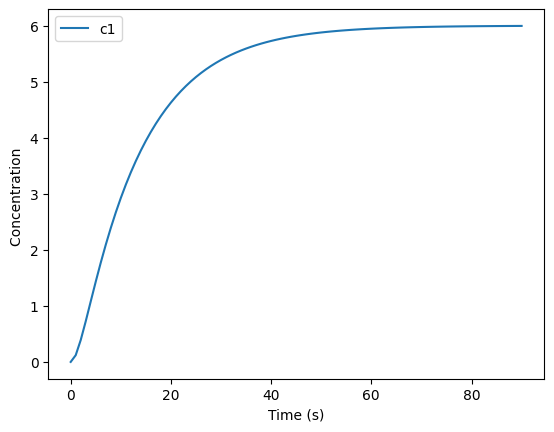

In [46]:
gain = 2
duration = 90
seconds = np.linspace(0, duration, duration + 1)
u = np.ones(duration+1)*gain
u = np.transpose(u)
time, outputs = ctl.forced_response(sys, T=seconds, U=u)
# Only want the musculatory system
plt.plot(time, outputs[1], label="c1")
plt.xlabel("Time (s)")
plt.ylabel("Concentration ")
plt.legend()
plt.show()

2.3. What happens if our model is inaccurate (for example there's something wrong with the patient) and the value $k_0 = 0.0$ instead?

Rip patient

**Exercise 3**: Designing a State Feedback Controller  
In this exercise, you will design a state feedback controller for the given system.

In a state feedback controller, the control input (u) is calculated as a linear combination of the system states (x) and a gain matrix (K). The control input is given by:

$u = -Kx$

The minus sign ensures that the feedback is negative, which is a requirement for stability in control systems. The gain matrix K is designed to place the closed-loop eigenvalues at desired locations, which helps achieve a specified system performance (e.g., faster settling time, reduced overshoot, etc.).

When implementing the state feedback controller, you want to create a closed-loop system, which means the controller's action is combined with the plant dynamics. In the state-space representation, the state update equation for the open-loop system is given by:

$\dot x = Ax + Bu$

Substituting the control input from the state feedback controller, we get:

$\dot x = Ax - BKx$

Which can be rewritten as:

$\dot x = (A - BK)x$

This is the closed-loop state update equation, and the matrix (A - B * K) represents the closed-loop system's A matrix (A_cl)

3.1. Determine the desired closed-loop eigenvalues for your system. For example, choose two eigenvalues with negative real parts, e.g., -1 and -2.  
3.2. Use ctl.place to find the state feedback gain matrix K that will place the closed-loop eigenvalues at the desired locations:

In [48]:
desired_eigvals = np.array([-1, -2])
K = ctl.place(sys.A, sys.B, desired_eigvals)
print("State feedback gain matrix K:", K)

State feedback gain matrix K: [[1.53333333 5.33333333]]


3.3. Implement the state feedback controller by updating the A matrix with the state feedback gain matrix K:

In [49]:
A_cl = sys.A - sys.B.dot(K)
print("Closed-loop A matrix:", A_cl)
eigvals = np.linalg.eigvals(A_cl)
print("Eigenvalues:", eigvals)


Closed-loop A matrix: [[-2.5 -7.5]
 [ 0.1 -0.5]]
Eigenvalues: [-2. -1.]


3.4. Create the closed-loop state space system using the updated A matrix:

In [58]:
sys_cl = ctl.ss(A_cl, sys.B, sys.C, sys.D)

3.5 Simulate the closed-loop system's response to a step input. 

Define a time vector for simulation using np.linspace, e.g., from 0 to 90 seconds with 1000 points:

In [59]:
time = np.linspace(0, 90, 1000)

Calculate the step response of the open and closed-loop system using ctl.step_response:

In [60]:
t1, y1 = ctl.step_response(sys, time)
t2, y2 = ctl.step_response(sys_cl, time)

Plot the step responses of both the open-loop and closed-loop systems using matplotlib:

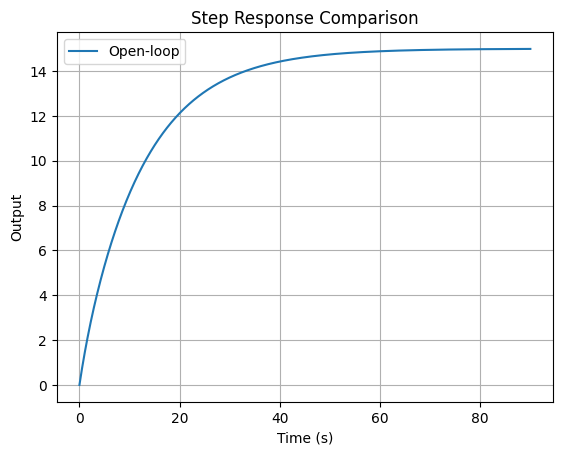

In [62]:
import matplotlib.pyplot as plt

plt.plot(t1, y1[0][0][:], label='Open-loop')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('Step Response Comparison')
plt.legend()
plt.grid(True)
plt.show()

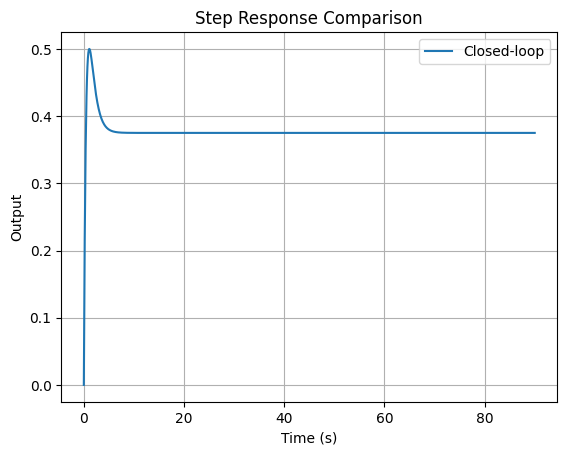

In [64]:
import matplotlib.pyplot as plt

plt.plot(t2, y2[0][0][:], label='Closed-loop')
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('Step Response Comparison')
plt.legend()
plt.grid(True)
plt.show()

3.6 Repeat steps 3.1 to 3.5 with different desired closed-loop eigenvalues. Observe how the choice of eigenvalues affects the step response and system performance (e.g., settling time, overshoot, and steady-state error).  

3.7 Compare the closed-loop system's performance with different desired closed-loop eigenvalues (analyze the step responses). What do you observe about the relationship between the desired eigenvalues and the system's performance? Write down your observations.  